# Cross-validation for Boston housing values  

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from sklearn.model_selection import KFold

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

#### Load original Boston housing dataset

In [3]:
boston = pd.read_csv("Boston.csv")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,538.0,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,469.0,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,469.0,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,458.0,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,458.0,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Using all variables  

In [4]:
Y = boston["medv"]
X_full = boston.drop(["medv"], axis=1)
col_names = X_full.columns.values
X_full = X_full.values

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [6]:
# Generate data sets
tests = []
trains = []

for i, (train_idx, test_idx) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_idx], X_full[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    tests.append([X_test, Y_test])
    trains.append([X_train, Y_train])
    # save data for R-BART
    np.savetxt(
        f"boston_x-train_{i}.csv",
        X_train,
        delimiter=",",
        header=",".join(col_names),
        comments="",
    )
    np.savetxt(
        f"boston_x-test_{i}.csv",
        X_test,
        delimiter=",",
        header=",".join(col_names),
        comments="",
    )
    np.savetxt(
        f"boston_y-train_{i}.csv", Y_train, delimiter=",", header="medv", comments=""
    )
    np.savetxt(
        f"boston_y-test_{i}.csv", Y_test, delimiter=",", header="medv", comments=""
    )

## Run R-BART  
This generate an output file `Boston_housing_values-R_02_CV.rout`  

In [7]:
!R CMD BATCH Boston_housing_values-R_02_CV.r

### RMSD and MAD

In [8]:
cv_scores = {
    "0": {},
    "1": {},
    "2": {},
    "3": {},
    "4": {},
}
rmse = []
mad = []

cv_scores_t = {
    "0": {},
    "1": {},
    "2": {},
    "3": {},
    "4": {},
}
rmse_t = []
mad_t = []

for j in range(len(tests)):
    # Out-of-sample
    y_test = tests[j][1].values
    new_y = np.loadtxt(
        f"y_pred_R-BART_{j:02d}.csv",
        skiprows=1,
        converters={0: lambda x: np.nan},
        delimiter=",",
    )[:, 1:]

    rmses = np.mean((new_y.squeeze() - y_test) ** 2, axis=1) ** 0.5
    rmse = np.mean(rmses)
    mads = np.median(np.abs(new_y.squeeze() - y_test), axis=1)
    mad = np.mean(mads)
    cv_scores[f"{j}"] = (rmse, np.std(rmses), mad, np.std(mads))

#     # In-sample...
#     y_train = trains[j][1].values
#     # results with all variables
#     data = np.stack([np.loadtxt(f"trace_R-BART_{j:02d}_{i}.csv", skiprows=1, usecols=range(1, 406), delimiter=',')
#                      for i in range(1, 5)])
#     idata_R = az.from_dict({"sigma":data[:,:,0],
#                             "y_hat":data[:,:,1:]})
#     y_pred = idata_R.posterior["y_hat"].stack(samples=["chain", "draw"])
# #     new_y = np.loadtxt(f"y_pred_R-BART_{j:02d}.csv",
# #                        skiprows=1,
# #                        converters= {0: lambda x: np.nan},
# #                        delimiter=',')[:, 1:]
#     print(len(y_pred.squeeze()), len(y_train))
#     rmses_t = np.mean((y_pred.squeeze().T - y_train)**2, axis=1)**0.5
#     rmse_t = np.mean(rmses_t)
#     mads_t = np.median(np.abs(y_pred.squeeze().T - y_train), axis=1)
#     mad_t = np.mean(mads_t)
#     cv_scores_t[f"{j}"] = (rmse_t, np.std(rmses_t), mad_t, np.std(mads_t))

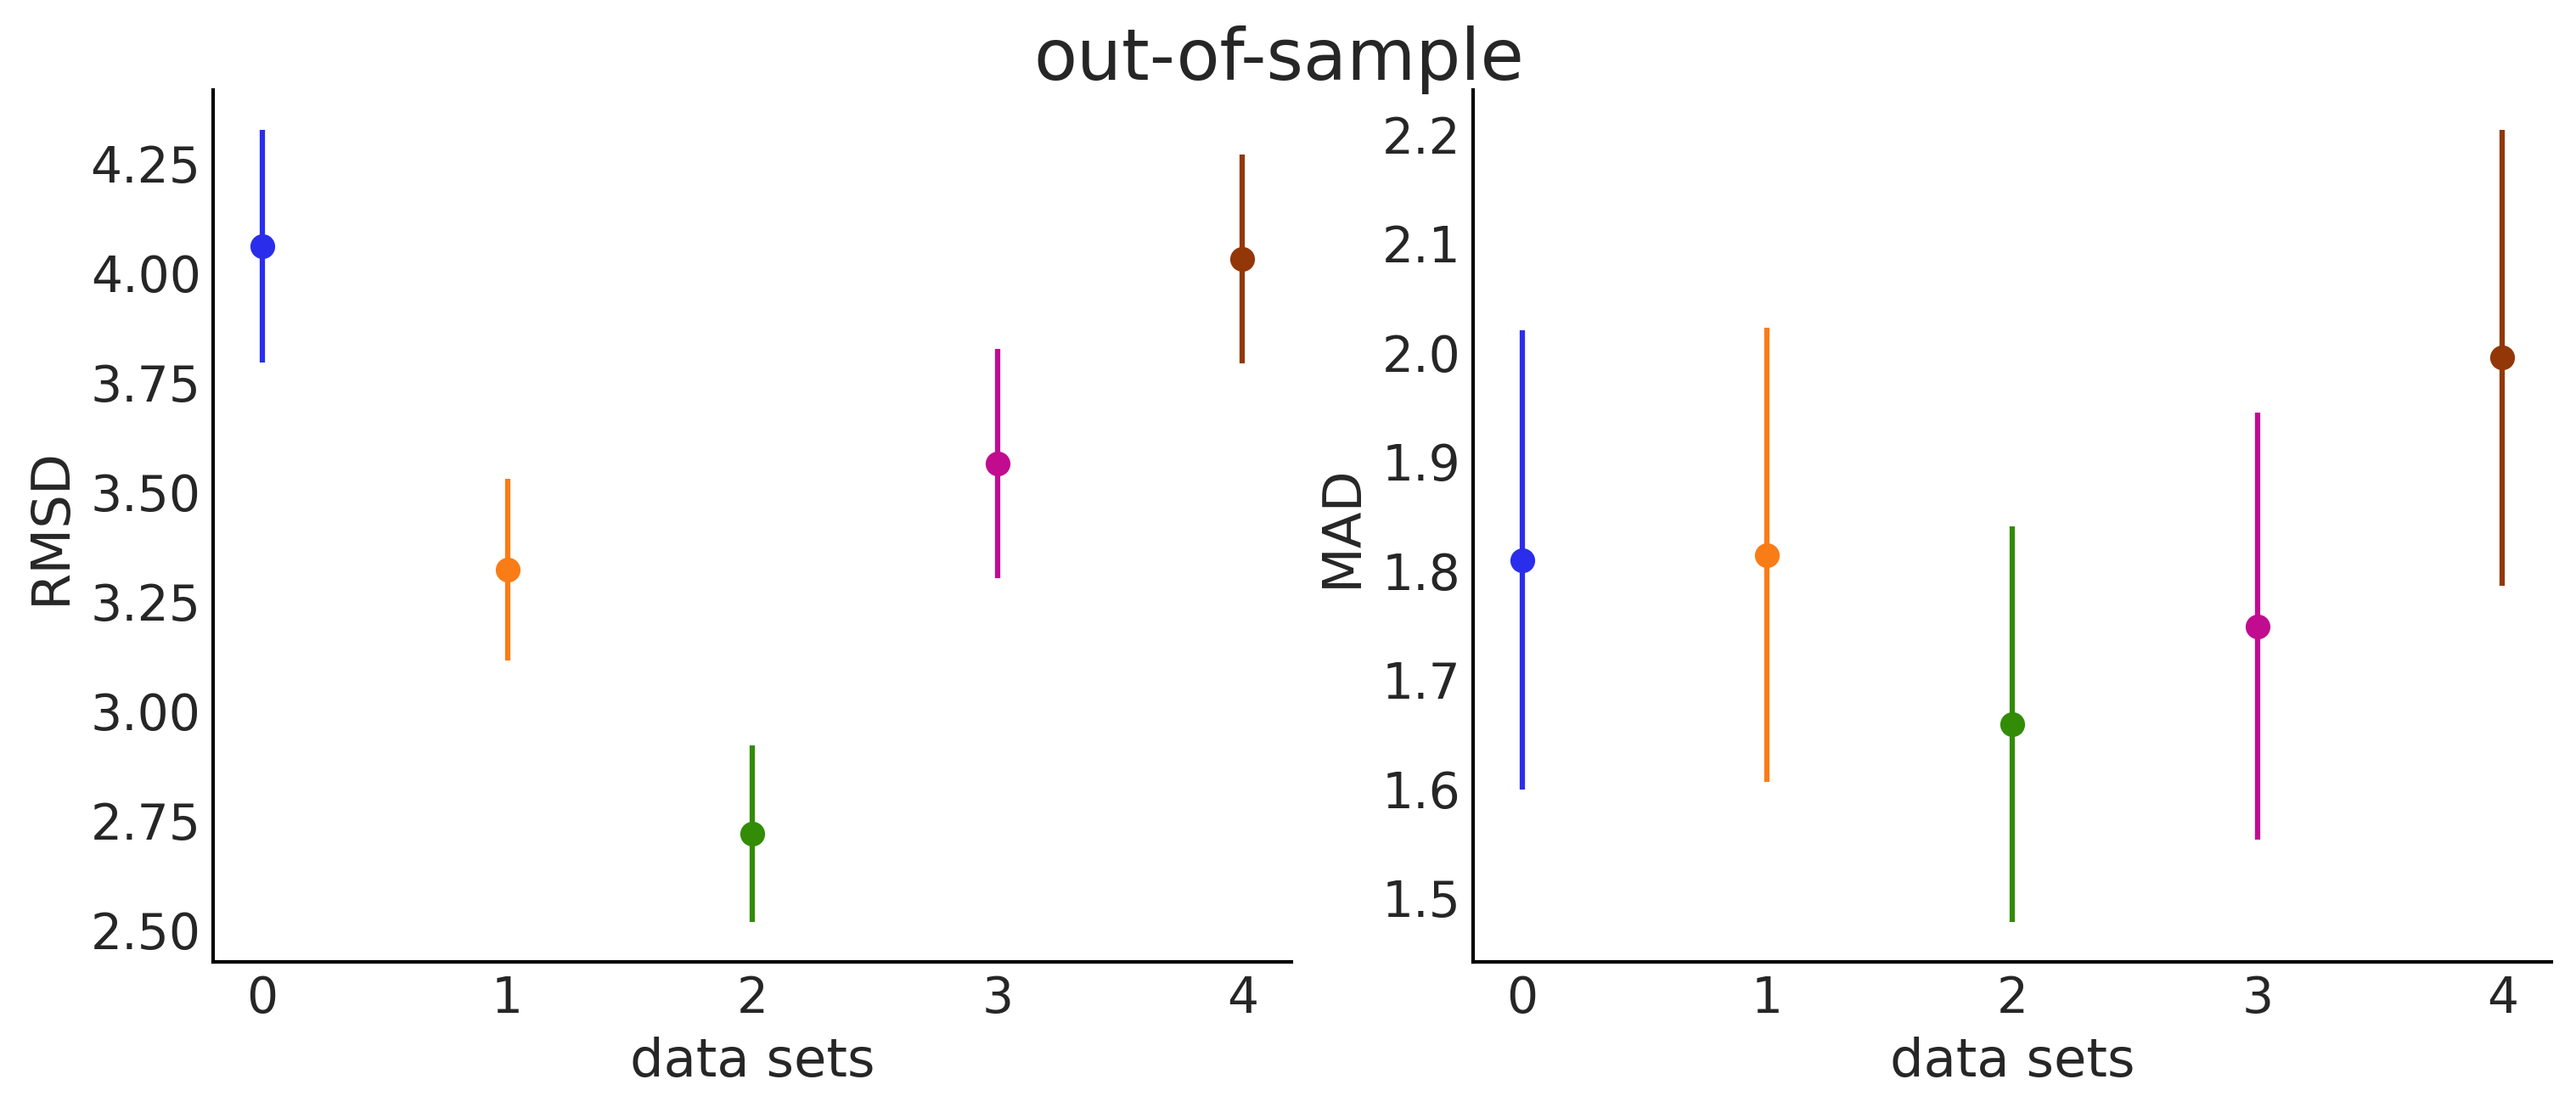

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, (k, v) in enumerate(cv_scores.items()):
    axes[0].errorbar(i, v[0], v[1], fmt="o")
    axes[1].errorbar(i, v[2], v[3], fmt="o")

axes[0].set_ylabel("RMSD")
axes[1].set_ylabel("MAD")
axes[0].set_xlabel("data sets")
axes[1].set_xlabel("data sets")
fig.text(0.4, 1.0, "out-of-sample", fontsize=20);

### Observed vs Predicted  

0 9.736341532306872
1 8.69197330353792
2 9.661226899477288
3 8.573987795773956
4 9.12397093520126


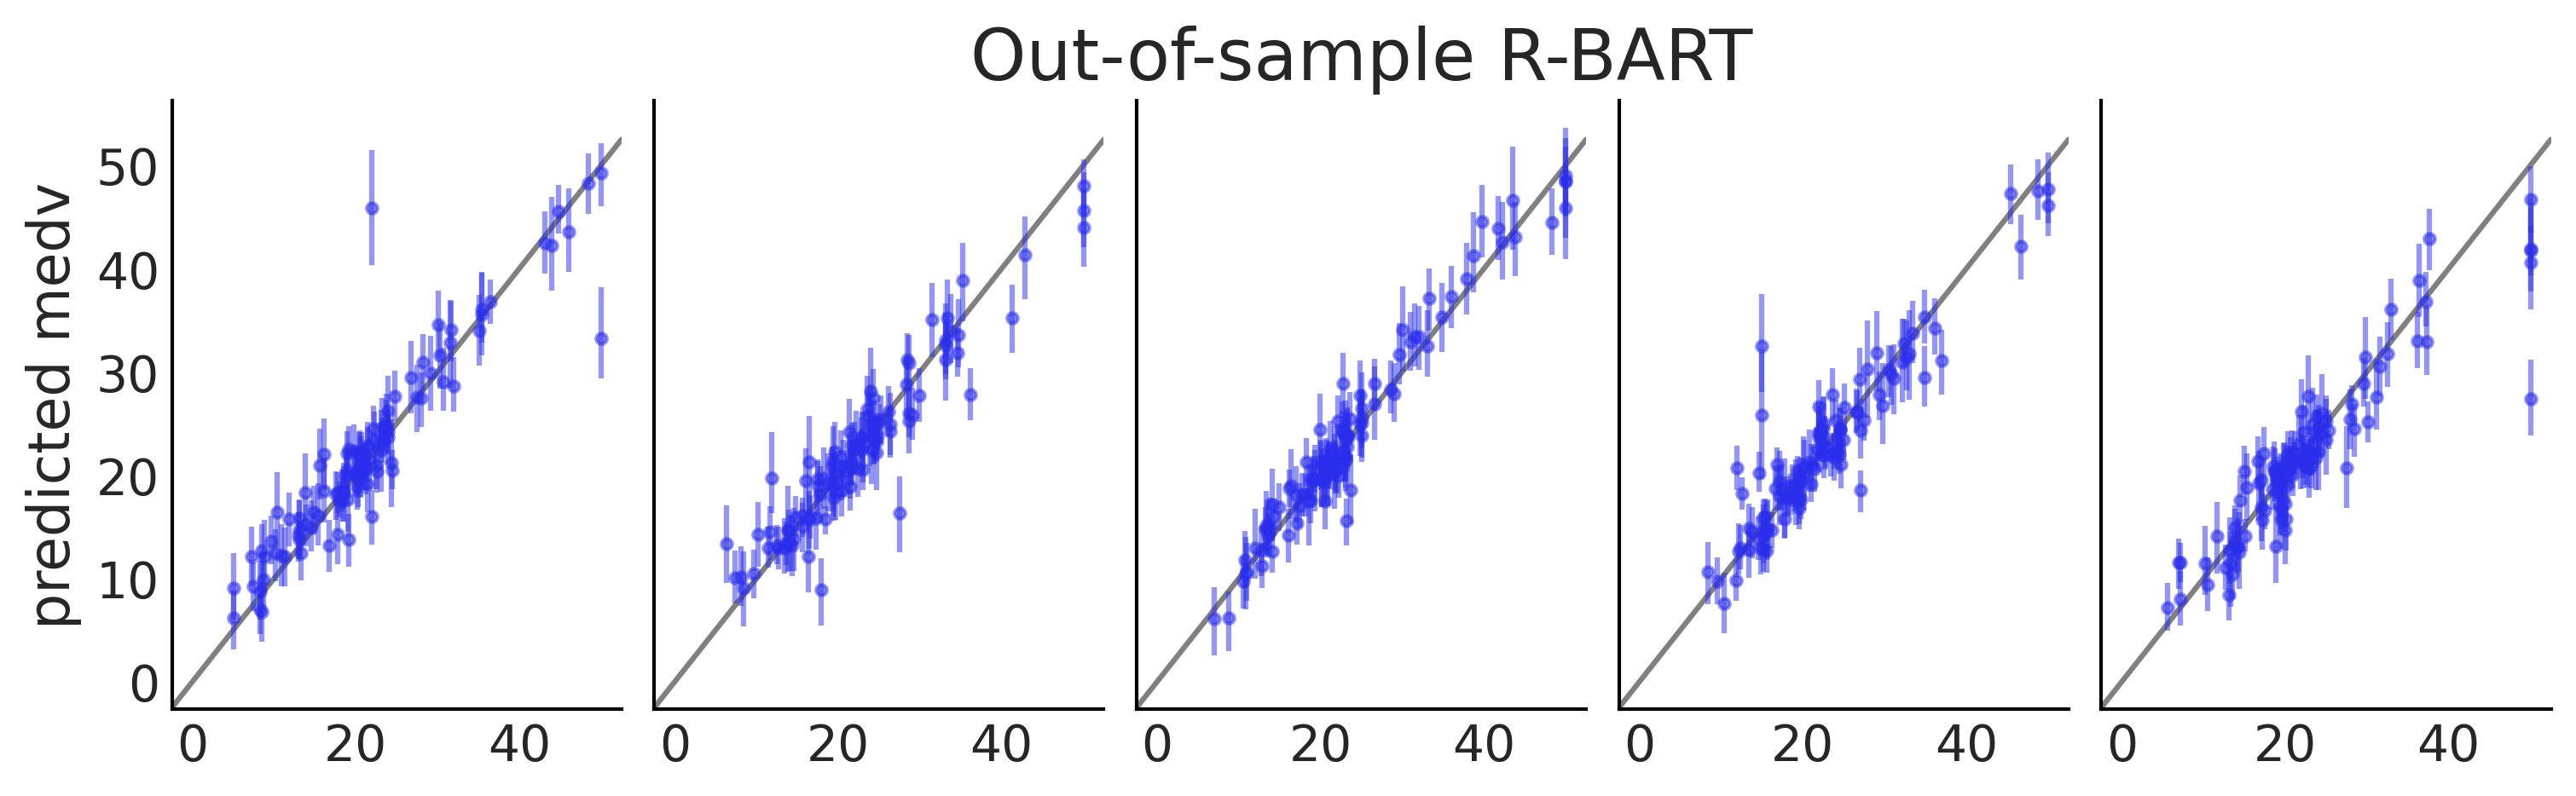

In [10]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10, 3))

axs = axes.ravel()

for j in range(len(tests)):
    ax = axs[j]
    ax.axline([0, 0], [1, 1], color="0.5")
    # load data
    Y = tests[j][1].values
    y_pred = np.loadtxt(
        f"y_pred_R-BART_{j:02d}.csv",
        skiprows=1,
        converters={0: lambda x: np.nan},
        delimiter=",",
    )[:, 1:]
    # Out-of-sample
    mean_y = np.median(y_pred, axis=0)
    mean = np.mean(y_pred)
    hdi = az.hdi(y_pred, hdi_prob=0.9)
    yerr = np.vstack([mean_y - hdi[:, 0], hdi[:, 1] - mean_y])
    ax.errorbar(Y, mean_y, yerr, linestyle="None", marker=".", alpha=0.5)
    print(j, np.mean((Y - mean) ** 2) ** 0.5)
    # In-sample...
    # ...

axs[0].set_ylabel("predicted medv", fontsize=16)
axs[2].set_title("Out-of-sample R-BART", fontsize=20);

# plt.savefig("boston-R_obs-pred.png", bbox_inches="tight")

## PyMC-BART  
Using all variables, and gamma distribuition.

In [11]:
Y = boston["medv"]
X_full = boston.drop(["medv"], axis=1)
col_names = X_full.columns.values
X_full = X_full.values

In [12]:
with pm.Model() as model_pmb:
    α = pm.HalfNormal("α", 20)
    μ_ = pmb.BART("μ_", X_full, np.log(Y), m=200)
    μ = pm.Deterministic("μ", np.exp(μ_))
    sigma = (μ**2 / α) ** 0.5
    y = pm.Gamma("y", mu=μ, sigma=sigma, observed=Y)
    idata_pmb = pm.sample(
        chains=4,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 280 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


3.5492354332875715


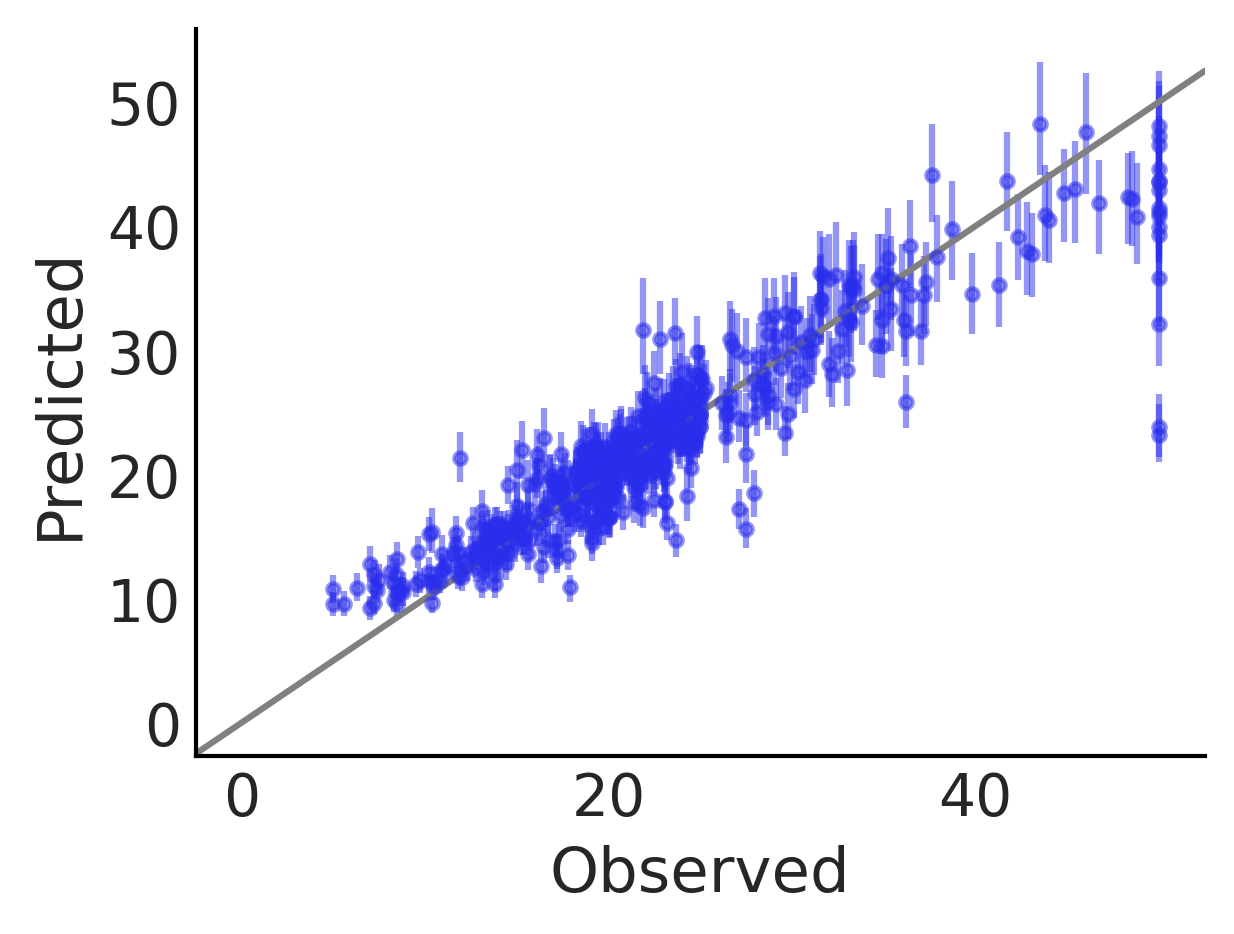

In [13]:
fig = plt.figure(figsize=(4, 3))

y_pred = idata_pmb.posterior["μ"].stack(samples=["chain", "draw"])
mean_y = y_pred.median("samples")
mean = y_pred.mean("samples")
hdi = az.hdi(y_pred.T.values, hdi_prob=0.9)
yerr = np.vstack([mean_y - hdi[:, 0], hdi[:, 1] - mean_y])
plt.errorbar(Y, mean_y, yerr, linestyle="None", marker=".", alpha=0.5)
plt.axline([0, 0], [1, 1], color="0.5")
plt.ylabel("Predicted")
plt.xlabel("Observed")
print(np.mean((Y - mean) ** 2) ** 0.5)

In [14]:
scores_pmb = {
    "0": {},
    "1": {},
    "2": {},
    "3": {},
    "4": {},
}

4.045944644156053
3.192262080747039
2.966761019688081
3.1410699860385463
4.190654775808018


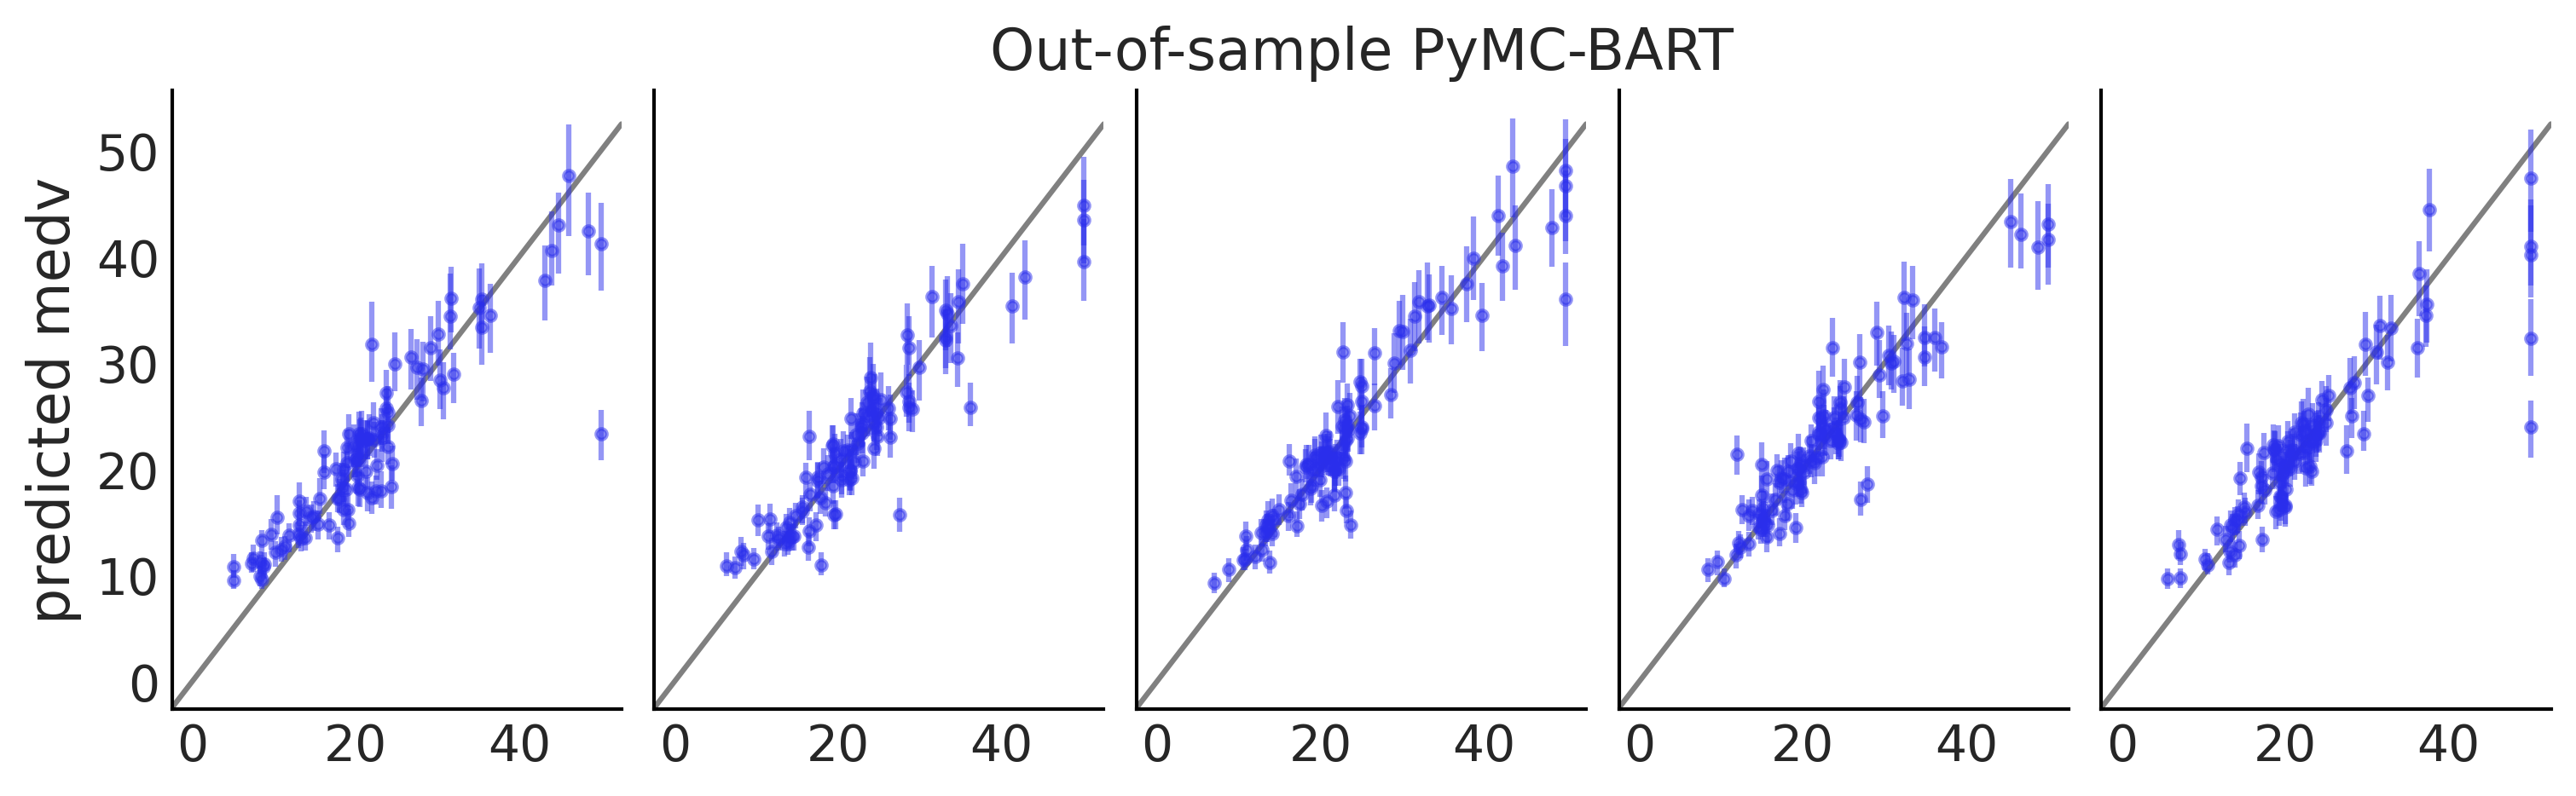

In [17]:
fig, axes = plt.subplots(1, 5, sharey=True, figsize=(10, 3))

axs = axes.ravel()

for i in range(len(tests)):
    ax = axs[i]
    ax.axline([0, 0], [1, 1], color="0.5")
    # Out-of-sample
    y_test = tests[i][1].values
    x_test = tests[i][0]

    μ_pred = np.exp(
        pmb.utils._sample_posterior(
            μ_.owner.op.all_trees,
            x_test,
            np.random.default_rng(RANDOM_SEED),
            size=500,
        ).squeeze()
    )

    mean = μ_pred.mean(0)
    hdi = az.hdi(μ_pred, hdi_prob=0.9)
    yerr = np.vstack([mean - hdi[:, 0], hdi[:, 1] - mean])

    ax.errorbar(
        y_test,
        mean,
        yerr,
        linestyle="None",
        marker=".",
        alpha=0.5,
    )
    print(np.mean((y_test - mean) ** 2) ** 0.5)
    # RMDS and MADs
    rmses = np.mean((μ_pred.squeeze() - y_test) ** 2, axis=1) ** 0.5
    rmse = np.mean(rmses)
    mads = np.median(np.abs(μ_pred.squeeze() - y_test), axis=1)
    mad = np.mean(mads)
    scores_pmb[f"{i}"] = (rmse, np.std(rmses), mad, np.std(mads))

axs[0].set_ylabel("predicted medv", fontsize=16)
axs[2].set_title("Out-of-sample PyMC-BART", fontsize=16);

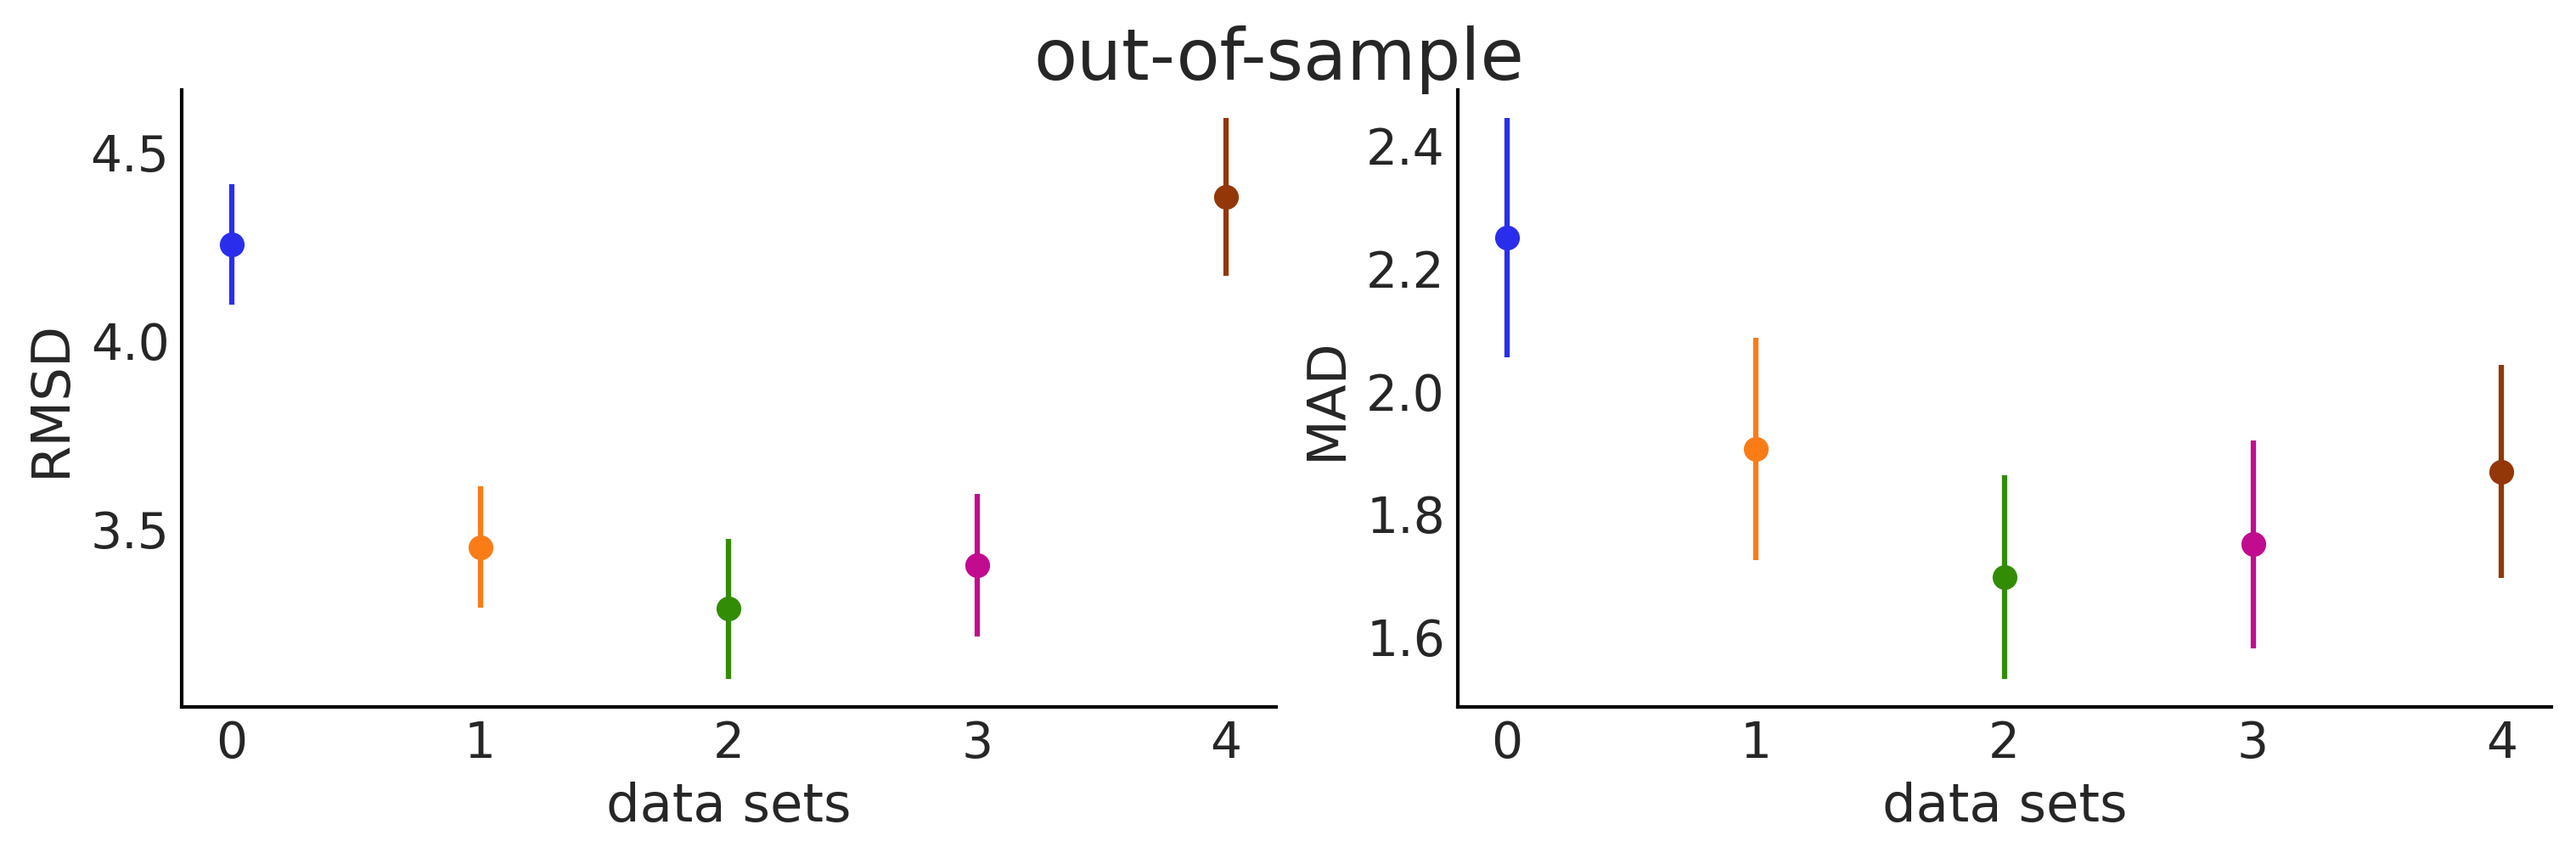

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i, (k, v) in enumerate(scores_pmb.items()):
    axes[0].errorbar(i, v[0], v[1], fmt="o")
    axes[1].errorbar(i, v[2], v[3], fmt="o")

axes[0].set_ylabel("RMSD")
axes[1].set_ylabel("MAD")
axes[0].set_xlabel("data sets")
axes[1].set_xlabel("data sets")
fig.text(0.4, 1.0, "out-of-sample", fontsize=20);